In [2]:
# Aggregating data according to AOD, WV, Precip, and Tau. Figures for CalRad Paper
# ----------------------------------------------------------------------------------------------

# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

## Import statements
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xray
import kray #### Custom functions for manipulating xray structures
from scipy import interpolate as interp
from scipy.stats.stats import pearsonr
from scipy import stats

# OS interaction
import sys, pickle, os

# import subplots function for plotting
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('paper')
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph

# Solargeometry
import solargeo

## Directory listing
dir_data = '/Users/karllapo/gdrive/SnowHydrology/proj/CloudClimatology/data'
dir_print = '/Users/karllapo/gdrive/SnowHydrology/proj/CloudClimatology/Graphics'

# Directory for basemap pickle files
dir_bmap = '/Users/karllapo/gdrive/SnowHydrology/proj/CloudClimatology/data/basemap'

In [3]:
####################################################################################################
# Load Data
####################################################################################################
os.chdir(dir_data)
grobs = xray.open_dataset('grobs.daily.nc')
grobs_diff = xray.open_dataset('grobs_bias.daily.nc')
anom_day = xray.open_dataset('tau_anom.daily.nc')
anom_mon = xray.open_dataset('tau_anom.monthly.nc')
tau = xray.open_dataset('tau.daily.nc')

## Names
pr_names = ['mtclim','nldas','syn','wrf']
num_products = np.size(pr_names)
grouping = ['north cv','south cv','west of crest','foothills','east of crest']

## Transmissivity
tau_products = xray.Dataset()
pr_names_plot = ['mtclim','nldas','syn','wrf','grobs']
for pr in pr_names_plot:
    tau_products[pr] = grobs[pr]/(np.sin(grobs.el*np.pi/180)*1365)

#### Role of precipitation and tau anomalies
- Screening for precipitation puts most points in the upper left quadrant (anomalously dark with a high bias in products)
- High biases still exist in the no rain population
- Suggests that methods (or observations) have systematic error during periods with synoptically forced clouds

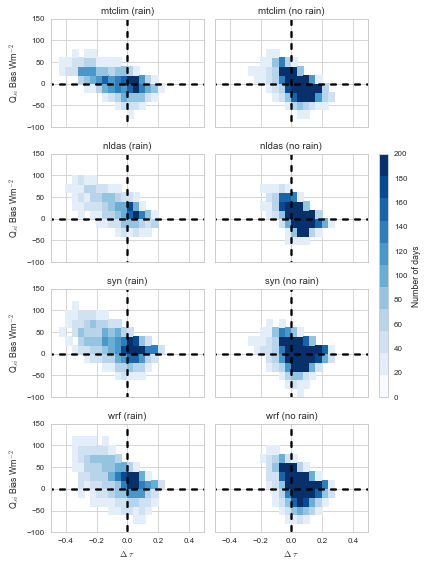

In [3]:
#############################
#### Precip Density Plot ####
#############################
#### Anomaly vs bias, (RAIN)
# Set up details
groups_for_plot = grouping
colsche = kgraph.SRON(len(np.atleast_1d(groups_for_plot)))
f = plt.figure(figsize=(6,8))
gs = matplotlib.gridspec.GridSpec(4,3,width_ratios=np.append(np.ones(2)*16,np.array(1.)))
cmin = 0
cmax = 200
ncol = 11
dcol = (cmax-cmin)/(ncol-1)
cmap = kgraph.cmap_discretize(cm.Blues,ncol)

# Rain screening
pthresh = 0 # Threshold between rainy and non-rainy days
grobs_diff_thresh = grobs_diff.where(grobs_diff.precip > pthresh)
anom_thresh = anom_day.where(anom_day.precip > pthresh)

## No Rain
for m,pr in enumerate(pr_names):
    ax = plt.subplot(gs[m,0])
    for n,gr in enumerate(groups_for_plot):
        # axis lines
        ax.plot(np.array((-1,1)),np.array((0,0)),'k--')
        ax.plot(np.array((0,0)),np.array((-1000,1000)),'k--')
        
        X = anom_thresh.anom_mean.values.flatten()[np.nonzero(~np.isnan(anom_thresh.anom_mean.values.flatten()) &\
                                                              ~np.isnan(grobs_diff_thresh[pr].values.flatten()))]
        Y = grobs_diff_thresh[pr].values.flatten()[np.nonzero(~np.isnan(anom_thresh.anom_mean.values.flatten()) &\
                                                              ~np.isnan(grobs_diff_thresh[pr].values.flatten()))]
        H, xedges, yedges = np.histogram2d(X,Y,bins=(np.arange(-.6,.6,.04),np.arange(-200,200,20)))
        H = np.ma.masked_array(H, H < cmin+dcol)
        X, Y = np.meshgrid(xedges, yedges)
        im = ax.pcolormesh(X.T, Y.T, H,cmap=cmap,vmin=cmin,vmax=cmax)

    ## Formatting
    ax.set_ylabel('Q$_{si}$ Bias Wm$^{-2}$')
    if m == len(pr_names)-1:
        ax.set_xlabel('$\Delta$ $\\tau$')
    else:
        ax.set_xticklabels([])
    ax.set_title(pr+' (rain)')
    ax.set_ylim(-100,150)
    ax.set_xlim(-.5,.5)
    ax.grid()

# Rain screening
# pthresh = 1 # Threshold between rainy and non-rainy days
grobs_diff_thresh = grobs_diff.where(grobs_diff.precip <= pthresh)
anom_thresh = anom_day.where(anom_day.precip <= pthresh)
    
## Rain
for m,pr in enumerate(pr_names):
    ax = plt.subplot(gs[m,1])
    for n,gr in enumerate(groups_for_plot):
        # axis lines
        ax.plot(np.array((-1,1)),np.array((0,0)),'k--')
        ax.plot(np.array((0,0)),np.array((-1000,1000)),'k--')
        
        X = anom_thresh.anom_mean.values.flatten()[np.nonzero(~np.isnan(anom_thresh.anom_mean.values.flatten()) &\
                                                              ~np.isnan(grobs_diff_thresh[pr].values.flatten()))]
        Y = grobs_diff_thresh[pr].values.flatten()[np.nonzero(~np.isnan(anom_thresh.anom_mean.values.flatten()) &\
                                                              ~np.isnan(grobs_diff_thresh[pr].values.flatten()))]
        H, xedges, yedges = np.histogram2d(X,Y,bins=(np.arange(-.6,.6,.04),np.arange(-200,200,20)))
        H = np.ma.masked_array(H, H < cmin+dcol)
        X, Y = np.meshgrid(xedges, yedges)
        im = ax.pcolormesh(X.T, Y.T, H,cmap=cmap,vmin=cmin,vmax=cmax)

    ## Formatting
    if m == len(pr_names)-1:
        ax.set_xlabel('$\Delta$ $\\tau$')
    else:
        ax.set_xticklabels([])
    ax.set_title(pr+' (no rain)')
    ax.set_yticklabels([])
    ax.set_ylim(-100,150)
    ax.set_xlim(-.5,.5)
    ax.grid()

# Colorbar
caxi = plt.subplot(gs[1:3,2])
cbar=plt.colorbar(im, cax=caxi, orientation = "vertical",spacing='proportional')
cbar.ax.set_ylabel('Number of days')
plt.tight_layout()

# Output
os.chdir(dir_print)
fname = 'Tau_Bias.Rain.Density.pdf'
f.savefig(fname)

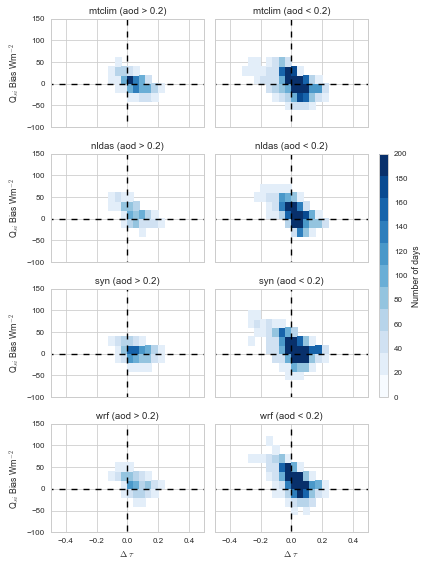

In [4]:
##############################
#### Aerosol Density Plot ####
##############################
#### Anomaly vs bias, (Aerosols)
# Set up details
groups_for_plot = ['south cv']
colsche = kgraph.SRON(len(np.atleast_1d(groups_for_plot)))
f = plt.figure(figsize=(6,8))
gs = matplotlib.gridspec.GridSpec(4,3,width_ratios=np.append(np.ones(2)*16,np.array(1.)))
cmin = 0
cmax = 200
ncol = 11
dcol = (cmax-cmin)/(ncol-1)
cmap = kgraph.cmap_discretize(cm.Blues,ncol)

# AOD screening
aod_thresh = .2 # Threshold between smog and no smog
grobs_diff_thresh = grobs_diff.where(grobs_diff.aod >= aod_thresh)
anom_thresh = anom_day.where(anom_day.aod >= aod_thresh)

## Smoggy
for m,pr in enumerate(pr_names):
    ax = plt.subplot(gs[m,0])    
    for n,gr in enumerate(groups_for_plot):
        # axis lines
        ax.plot(np.array((-1,1)),np.array((0,0)),'k--')
        ax.plot(np.array((0,0)),np.array((-1000,1000)),'k--')
        
        X = anom_thresh.anom_mean.values.flatten()[np.nonzero(~np.isnan(anom_thresh.anom_mean.values.flatten()) &\
                                                              ~np.isnan(grobs_diff_thresh[pr].values.flatten()))]
        Y = grobs_diff_thresh[pr].values.flatten()[np.nonzero(~np.isnan(anom_thresh.anom_mean.values.flatten()) &\
                                                              ~np.isnan(grobs_diff_thresh[pr].values.flatten()))]
        H, xedges, yedges = np.histogram2d(X,Y,bins=(np.arange(-.6,.6,.04),np.arange(-200,200,20)))
        H = np.ma.masked_array(H, H < cmin+dcol)
        X, Y = np.meshgrid(xedges, yedges)
        ax.pcolormesh(X.T, Y.T, H,cmap=cmap,vmin=cmin,vmax=cmax)

    ## Formatting
    ax.set_ylabel('Q$_{si}$ Bias Wm$^{-2}$')
    if m == len(pr_names)-1:
        ax.set_xlabel('$\Delta$ $\\tau$')
    else:
        ax.set_xticklabels([])
    ax.set_title(pr+' (aod > 0.2)')
    ax.set_ylim(-100,150)
    ax.set_xlim(-.5,.5)
    ax.grid()

# aerosol screening
grobs_diff_thresh = grobs_diff.where(grobs_diff.aod < aod_thresh)
anom_thresh = anom_day.where(anom_day.aod < aod_thresh)
    
## Not smoggy
for m,pr in enumerate(pr_names):
    ax = plt.subplot(gs[m,1])
    for n,gr in enumerate(groups_for_plot):
        # axis lines
        ax.plot(np.array((-1,1)),np.array((0,0)),'k--')
        ax.plot(np.array((0,0)),np.array((-1000,1000)),'k--')
        
        X = anom_thresh.anom_mean.values.flatten()[np.nonzero(~np.isnan(anom_thresh.anom_mean.values.flatten()) &\
                                                              ~np.isnan(grobs_diff_thresh[pr].values.flatten()))]
        Y = grobs_diff_thresh[pr].values.flatten()[np.nonzero(~np.isnan(anom_thresh.anom_mean.values.flatten()) &\
                                                              ~np.isnan(grobs_diff_thresh[pr].values.flatten()))]
        H, xedges, yedges = np.histogram2d(X,Y,bins=(np.arange(-.6,.6,.04),np.arange(-200,200,20)))
        H = np.ma.masked_array(H, H < cmin+dcol)
        X, Y = np.meshgrid(xedges, yedges)
        im = ax.pcolormesh(X.T, Y.T, H,cmap=cmap,vmin=cmin,vmax=cmax)

    ## Formatting
    if m == len(pr_names)-1:
        ax.set_xlabel('$\Delta$ $\\tau$')
    else:
        ax.set_xticklabels([])
    ax.set_title(pr+' (aod < 0.2)')
    ax.set_yticklabels([])
    ax.set_ylim(-100,150)
    ax.set_xlim(-.5,.5)
    ax.grid()
    
# Colorbar
caxi = plt.subplot(gs[1:3,2])
cbar=plt.colorbar(im, cax=caxi, orientation = "vertical",spacing='proportional')
cbar.ax.set_ylabel('Number of days')
plt.tight_layout()

# Output
os.chdir(dir_print)
fname = 'Tau_Bias.Aerosol.Density.pdf'
f.savefig(fname)

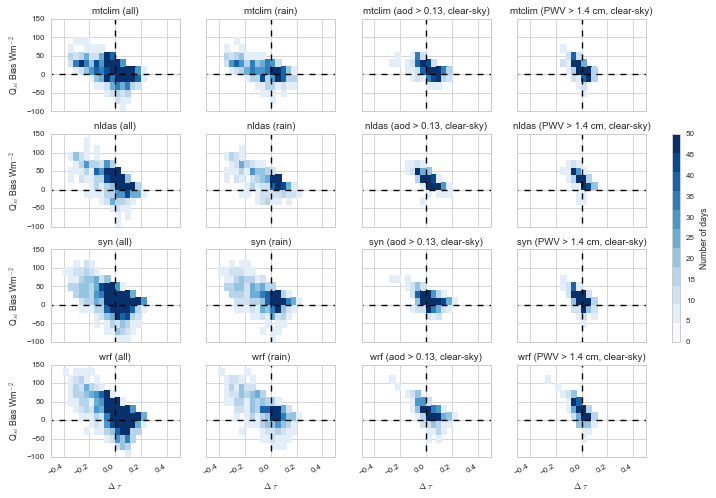

In [11]:
# ----------------------------------------------------------------------------------------
# Density Plot
# Anomaly vs bias (all)
# ----------------------------------------------------------------------------------------

# Set up details
groups_for_plot = ['south cv']
f = plt.figure(figsize=(10,8))
gs = matplotlib.gridspec.GridSpec(4,5,width_ratios=np.append(np.ones(4)*16,np.array(1.)))
cmin = 0
cmax = 50
ncol = 11
dcol = (cmax-cmin)/(ncol-1)
cmap = kgraph.cmap_discretize(cm.Blues,ncol)

anom_day_SCV = anom_day.loc[{'Grouping': 'south cv'}]
grobs_diff_SCV = grobs_diff.loc[{'Grouping': 'south cv'}]

## All
for m,pr in enumerate(pr_names):
    ax = plt.subplot(gs[m,0])
    for n,gr in enumerate(groups_for_plot):
        # axis lines
        ax.plot(np.array((-1,1)),np.array((0,0)),'k--')
        ax.plot(np.array((0,0)),np.array((-1000,1000)),'k--')
        
        X = anom_day_SCV.anom_mean.values.flatten()[np.nonzero(~np.isnan(anom_day_SCV.anom_mean.values.flatten()) &\
                                                               ~np.isnan(grobs_diff_SCV[pr].values.flatten()))]
        Y = grobs_diff_SCV[pr].values.flatten()[np.nonzero(~np.isnan(anom_day_SCV.anom_mean.values.flatten()) &\
                                                           ~np.isnan(grobs_diff_SCV[pr].values.flatten()))]
        H, xedges, yedges = np.histogram2d(X,Y,bins=(np.arange(-.6,.6,.04),np.arange(-200,200,20)))
        H = np.ma.masked_array(H, H < cmin+dcol)
        X, Y = np.meshgrid(xedges, yedges)
        im = ax.pcolormesh(X.T, Y.T, H,cmap=cmap,vmin=cmin,vmax=cmax)
    ## Formatting
    ax.set_ylabel('Q$_{si}$ Bias Wm$^{-2}$')
    if m == len(pr_names)-1:
        ax.set_xlabel('$\Delta$ $\\tau$')
    else:
        ax.set_xticklabels([])
    ax.set_title(pr+' (all)')
    ax.set_ylim(-100,150)
    ax.set_xlim(-.5,.5)
    ax.grid()

## Rain
pthresh = 0 # Threshold between rainy and non-rainy days
grobs_diff_thresh = grobs_diff_SCV.where(grobs_diff_SCV.precip > pthresh)
anom_thresh = anom_day_SCV.where(anom_day_SCV.precip > pthresh)

for m,pr in enumerate(pr_names):
    ax = plt.subplot(gs[m,1])    
    for n,gr in enumerate(groups_for_plot):
        # axis lines
        ax.plot(np.array((-1,1)),np.array((0,0)),'k--')
        ax.plot(np.array((0,0)),np.array((-1000,1000)),'k--')
        
        X = anom_thresh.anom_mean.values.flatten()[np.nonzero(~np.isnan(anom_thresh.anom_mean.values.flatten()) &\
                                                              ~np.isnan(grobs_diff_thresh[pr].values.flatten()))]
        Y = grobs_diff_thresh[pr].values.flatten()[np.nonzero(~np.isnan(anom_thresh.anom_mean.values.flatten()) &\
                                                              ~np.isnan(grobs_diff_thresh[pr].values.flatten()))]
        H, xedges, yedges = np.histogram2d(X,Y,bins=(np.arange(-.6,.6,.04),np.arange(-200,200,20)))
        H = np.ma.masked_array(H, H < cmin+dcol)
        X, Y = np.meshgrid(xedges, yedges)
        ax.pcolormesh(X.T, Y.T, H,cmap=cmap,vmin=cmin,vmax=cmax)

    ## Formatting
    if m == len(pr_names)-1:
        ax.set_xlabel('$\Delta$ $\\tau$')
    else:
        ax.set_xticklabels([])
    ax.set_title(pr+' (rain)')
    ax.set_yticklabels([])
    ax.set_ylim(-100,150)
    ax.set_xlim(-.5,.5)
    ax.grid()

## Smoggy
aod_thresh = .13 # Median aod value
grobs_diff_thresh = grobs_diff_SCV.where(grobs_diff_SCV.aod >= aod_thresh)
anom_thresh = anom_day_SCV.where(anom_day_SCV.aod >= aod_thresh)

for m,pr in enumerate(pr_names):
    ax = plt.subplot(gs[m,2])    
    for n,gr in enumerate(groups_for_plot):
        # axis lines
        ax.plot(np.array((-1,1)),np.array((0,0)),'k--')
        ax.plot(np.array((0,0)),np.array((-1000,1000)),'k--')
        
        X = anom_thresh.anom_mean.values.flatten()[np.nonzero(~np.isnan(anom_thresh.anom_mean.values.flatten()) &\
                                                              ~np.isnan(grobs_diff_thresh[pr].values.flatten()))]
        Y = grobs_diff_thresh[pr].values.flatten()[np.nonzero(~np.isnan(anom_thresh.anom_mean.values.flatten()) &\
                                                              ~np.isnan(grobs_diff_thresh[pr].values.flatten()))]
        H, xedges, yedges = np.histogram2d(X,Y,bins=(np.arange(-.6,.6,.04),np.arange(-200,200,20)))
        H = np.ma.masked_array(H, H < cmin+dcol)
        X, Y = np.meshgrid(xedges, yedges)
        ax.pcolormesh(X.T, Y.T, H,cmap=cmap,vmin=cmin,vmax=cmax)

    ## Formatting
    if m == len(pr_names)-1:
        ax.set_xlabel('$\Delta$ $\\tau$')
    else:
        ax.set_xticklabels([])
    ax.set_title(pr+' (aod > 0.13, clear-sky)')
    ax.set_yticklabels([])
    ax.set_ylim(-100,150)
    ax.set_xlim(-.5,.5)
    ax.grid()
    
## Water Vapor
wv_thresh = 1.4 # Median pwv value
grobs_diff_thresh = grobs_diff_SCV.where(grobs_diff_SCV.wv >= wv_thresh)
anom_thresh = anom_day_SCV.where(anom_day_SCV.wv >= wv_thresh)

for m,pr in enumerate(pr_names):
    ax = plt.subplot(gs[m,3])    
    for n,gr in enumerate(groups_for_plot):
        # axis lines
        ax.plot(np.array((-1,1)),np.array((0,0)),'k--')
        ax.plot(np.array((0,0)),np.array((-1000,1000)),'k--')
        
        X = anom_thresh.anom_mean.values.flatten()[np.nonzero(~np.isnan(anom_thresh.anom_mean.values.flatten()) &\
                                                              ~np.isnan(grobs_diff_thresh[pr].values.flatten()))]
        Y = grobs_diff_thresh[pr].values.flatten()[np.nonzero(~np.isnan(anom_thresh.anom_mean.values.flatten()) &\
                                                              ~np.isnan(grobs_diff_thresh[pr].values.flatten()))]
        H, xedges, yedges = np.histogram2d(X,Y,bins=(np.arange(-.6,.6,.04),np.arange(-200,200,20)))
        H = np.ma.masked_array(H, H < cmin+dcol)
        X, Y = np.meshgrid(xedges, yedges)
        ax.pcolormesh(X.T, Y.T, H, cmap=cmap, vmin=cmin, vmax=cmax)

    ## Formatting
    if m == len(pr_names)-1:
        ax.set_xlabel('$\Delta$ $\\tau$')
    else:
        ax.set_xticklabels([])
    ax.set_title(pr+' (PWV > 1.4 cm, clear-sky)')
    ax.set_yticklabels([])
    ax.set_ylim(-100,150)
    ax.set_xlim(-.5,.5)
    ax.grid()
    
# Colorbar
caxi = plt.subplot(gs[1:3,-1])
cbar=plt.colorbar(im, cax=caxi, orientation = "vertical",spacing='proportional')
cbar.ax.set_ylabel('Number of days')
plt.tight_layout()
f.autofmt_xdate()

# Output
os.chdir(dir_print)
fname = 'Tau_Bias.Density.'
f.savefig(fname + 'pdf')
f.savefig(fname + 'png')
f.savefig(fname + 'eps')

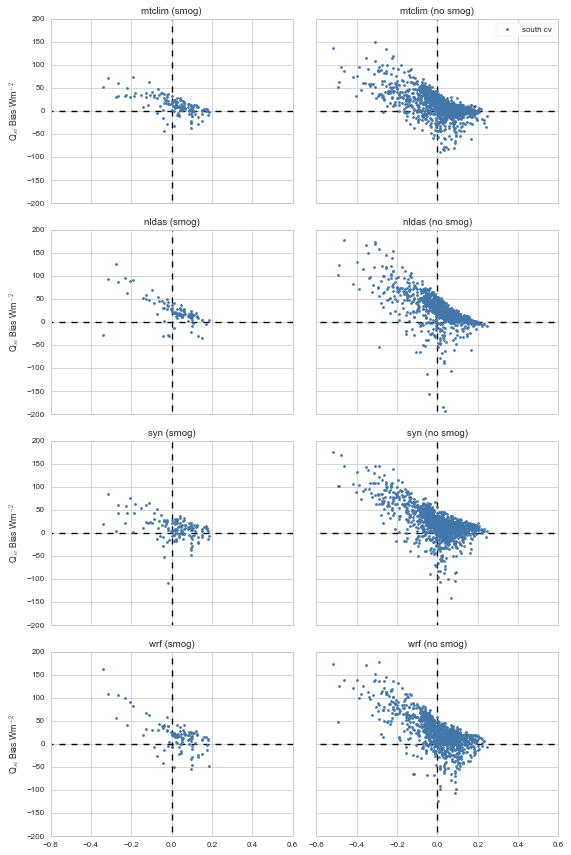

In [6]:
################
# Smoggy days ##
################

#### Anomaly vs bias, AOD screening
# Only use valley sites
# groups_for_plot = ['north cv','south cv','west of crest','foothills']
groups_for_plot = ['south cv']
colsche = kgraph.SRON(len(groups_for_plot))
f,axes = plt.subplots(4,2,figsize=(8,12),sharex='col',sharey='row')

# AOD screening
aod_thresh = .3 # Threshold between smog and no smog
grobs_diff_thresh = grobs_diff.where(grobs_diff.aod >= aod_thresh)
anom_thresh = anom_day.where(anom_day.aod >= aod_thresh)

## Scatter plots
for m,pr in enumerate(pr_names):
    ax = axes[m,0]
    for n,gr in enumerate(groups_for_plot):
        # axis lines
        ax.plot(np.array((-1,1)),np.array((0,0)),'k--')
        ax.plot(np.array((0,0)),np.array((-1000,1000)),'k--')
        
        # Daily anomaly and bias
        ax.plot(anom_thresh.anom_mean.loc[{'Grouping':gr}],\
                grobs_diff_thresh[pr].loc[{'Grouping':gr}],\
                '.',color=colsche[n],label=gr)
              
    ## Formatting
    ax.set_ylabel('Q$_{si}$ Bias Wm$^{-2}$')
    if m == len(pr_names):
        ax.set_xlabel('$\Delta$ $\\tau$')
    ax.set_title(pr+' (smog)')
    ax.set_ylim(-200,200)
    ax.set_xlim(-.6,.6)
    
###################
# Smog free days ##
###################
# aerosol screening
grobs_diff_thresh = grobs_diff.where(grobs_diff.aod < aod_thresh)
anom_thresh = anom_day.where(anom_day.aod < aod_thresh)

## Scatter plots
for m,pr in enumerate(pr_names):
    ax = axes[m,1]
    for n,gr in enumerate(groups_for_plot):
        # axis lines
        ax.plot(np.array((-1,1)),np.array((0,0)),'k--')
        ax.plot(np.array((0,0)),np.array((-1000,1000)),'k--')
        
        # Daily anomaly and bias
        ax.plot(anom_thresh.anom_mean.loc[{'Grouping':gr}],\
                grobs_diff_thresh[pr].loc[{'Grouping':gr}],\
                '.',color=colsche[n],label=gr)

    ## Formatting
    if m == 0:
        ax.legend(loc='best',frameon=True)
    if m == len(pr_names):
        ax.set_xlabel('$\Delta$ $\\tau$')
    ax.set_title(pr+' (no smog)')
    ax.set_ylim(-200,200)
    ax.set_xlim(-.6,.6)

plt.tight_layout()

# Output
os.chdir(dir_print)
fname = 'Tau_Bias.DailyScatter.AOD.png'
f.savefig(fname)

#### Role of aerosols and tau anomalies
- AOD @ Fresno doesn't seem to create negative tau anomalies
- Same relationship between tau and bias with aerosol screening and without
- Errors don't seem to be attributable to aersols

#### Lack of an aerosol influence:
- Aeronet only reports AOD on days without cloud cover
- days with cloud cover = positive tau anomaly
- Influence of aerosols minimal over long time periods, even when selecting for only periods with high aod (> .3) relative to influence of clouds

In [14]:
#### Hack the shit out of the violinplot because it has some really silly limitations
# Callable method for doing the kernel estimate
def violin_local(ax,vpstats, positions=None, widths=1, extrema=False):
    """Drawing function for violin plots.

    Call signature::

      violin(vpstats, positions=None, vert=True, widths=0.5,
             showmeans=False, showextrema=True, showmedians=False):

    Draw a violin plot for each column of `vpstats`. Each filled area
    extends to represent the entire data range, with optional lines at the
    mean, the median, the minimum, and the maximum.
    """
    # Collection
    artists={}
    
    # Statistical quantities to be plotted on the violins
    means = []
    mins = []
    maxes = []
    medians = []

    # Collections to be returned
    artists = {}
    if np.shape(np.shape(vpstats))[0] > 1:
        N = len(vpstats)
    else:
        N = 1
    datashape_message = ("List of violinplot statistics and `{0}` "
                         "values must have the same length")

    # Validate positions
    if positions is None:
        positions = range(1, N + 1)
    elif len(np.atleast_1d(positions)) != N:
        raise ValueError(datashape_message.format("positions"))

    # Validate widths
    if np.isscalar(widths):
        widths = [widths] * N
    elif len(np.atleast_1d(widths)) != N:
        raise ValueError(datashape_message.format("widths"))

    # Calculate ranges for statistics lines
    pmins = -0.25 * np.array(widths) + positions
    pmaxes = 0.25 * np.array(widths) + positions

    # Check whether we are rendering vertically or horizontally
    fill = ax.fill_betweenx
    perp_lines = ax.hlines
    par_lines = ax.vlines

    # Render violins
    bodies = []
    for stats, pos, width in zip(vpstats, positions, widths):
        # The 0.5 factor reflects the fact that we plot from v-p to
        # v+p
        vals = np.array(stats['vals'])
        vals = 0.5 * width * vals / vals.max()
        bodies += [fill(stats['coords'],
                        -vals + pos,
                        vals + pos,
                        facecolor='y',
                        alpha=0.3)]
        means.append(stats['mean'])
        mins.append(stats['min'])
        maxes.append(stats['max'])
        medians.append(stats['median'])
    artists['bodies'] = bodies
    
    # Render means
    artists['cmeans'] = perp_lines(means, pmins, pmaxes, colors='r')
    
    # Render extrema
    if extrema:
        artists['cmaxes'] = perp_lines(maxes, pmins, pmaxes, colors='r')
        artists['cmins'] = perp_lines(mins, pmins, pmaxes, colors='r')
        artists['cbars'] = par_lines(positions, mins, maxes, colors='r')
    
    return artists

def _kde_method(X, coords):
    kde = matplotlib.mlab.GaussianKDE(X, None)
    return kde.evaluate(coords)

# Actually build the violinplot statistics and removes nans
def build_violinplot(X,ax,pos=None,color=None,dim=1):            
    import kgraph
    # Dimension to operate along
#     if dim < 0. or dim > np.shape(X.shape):
#         raise ValueError('dim must be in range of dimensions of X')
    # Number of arrays provided for violinplots
    nx = X.shape[dim]
    
#     print(len(np.atleast_1d(color)))
#     if color is None:
#         color = kgraph.SRON(nx)
#     elif not len(np.atleast_1d(color)) == nx:
#         raise ValueError('color variable does not match data (length mismatch)')
    
#     # Validate positions
#     if pos is None:
#         pos = range(1, N + 1)
#     elif not len(np.atleast_1d(pos)) == nx:
#         raise ValueError('pos variable does not match data (length mismatch)')
    
    ## violinplots
    # pop the desired axis to the front
    X = np.rollaxis(X,dim)
    for n in np.arange(0,nx):
        # Remove NaNs
        xplot = X[n]
        xplot = xplot[~np.isnan(xplot)]
    
        if xplot.any():
            # Dictionary of violin statistics
            vpstats = matplotlib.cbook.violin_stats(xplot,_kde_method,points=200)
            position = [pos[n]]*1
            result = violin_local(ax,vpstats,positions=position)
            
            ## Format
            # Violin body and label
            for pc in result['bodies']:
                pc.set_facecolor(color[n])
                pc.set_edgecolor(color[n])
                pc.set_alpha(None)
            # Violin lines
            violinplotlines = ['cbars','cmins','cmeans','cmaxes']
            for vpl in violinplotlines:
                if vpl in result:
                    result[vpl].set_color('k')

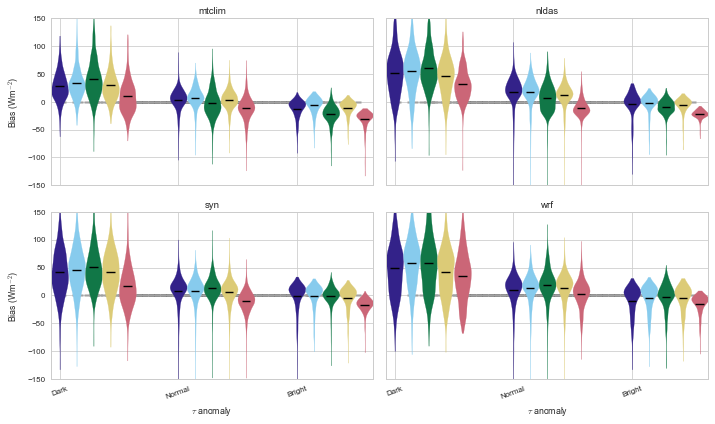

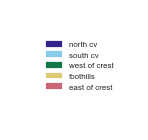

In [16]:
#### Bin according to tau anomaly
groups_for_plot = grouping
colsche = kgraph.SRON(len(groups_for_plot))
f,axes = plt.subplots(2,2,figsize=(10,6),sharex='col',sharey='row')
axes = axes.flatten()

# screening
tau_thresh = np.array((-1,-.1,.1,1))
# labels = ['$\Delta \\tau < -.1$','$-.1 < \Delta \\tau < .1$','$\Delta \\tau > .1$']
labels = ['Dark','Normal','Bright']

# Bin positions
pos_buffer = 2
num_pos = len(grouping)
num_group = len(labels)
bin_pos = [np.linspace((num_pos + pos_buffer) * n + 1, (num_pos +pos_buffer) * (n + 1) - pos_buffer,
           num=num_pos) for n in np.arange(num_group)]

for m,pr in enumerate(pr_names):
    ax = axes[m]
    for bin_num,lab in enumerate(labels):
        #### Organize data for plotting
        floor = tau_thresh[bin_num]
        ceil = tau_thresh[bin_num+1]
        grobs_diff_thresh = grobs_diff[pr].where((anom_day.anom_mean > floor) \
                                        & (anom_day.anom_mean < ceil)).values
        result = build_violinplot(grobs_diff_thresh, ax, bin_pos[bin_num], color=colsche, dim=0)

    ## Formatting
    ax.set_xticks(np.array(bin_pos)[:,0])
    if m > 1:
        ax.set_xticklabels(labels,rotation=20)
        ax.set_xlabel('$\\tau$ anomaly')
    ax.set_ylim(-150,150)
    if m == 0 or m == 2:
        ax.set_ylabel('Bias (Wm$^{-2}$)')
    ax.plot(np.array((bin_pos[0],bin_pos[-1])),np.zeros((2,1)),'k--',zorder=0)
    ax.set_title(pr)    
    
os.chdir(dir_print)
f.tight_layout()
f.savefig('Group.Bias.Cloudy_v_Clear.pdf')

## Legend (separate figure)
# Violinplot labels
handle = [matplotlib.patches.Patch(color=colsche[n], label=grouping[n]) \
          for n,p in enumerate(grouping)]
leg_fig = plt.figure(figsize=(2,2))
leg_ax = plt.axes()
leg_ax.axis('off')
_out = leg_ax.legend(handles=handle,loc='center',ncol=1)
os.chdir(dir_print)
leg_fig.savefig('ViolinPlotLegend.pdf')

#### Categorizing biases according to tau anomalies
Daily $\tau$ anomalies allow us to categorize $Q_{si}$ biases of products against observations

$\tau$ anomaly | Physical Meaning | $Q_{si}$ Interpretation
--- | --- | --- 
$\Delta \tau < -.1$ | Darker than expected (Cloudy) | Dark cloudy periods drive largest biases
$-.1 < \Delta \tau < .1$ | Normal conditions | Daily biases closer to zero, most errors within obs. uncertainty
$\Delta \tau > .1$ | Clearer than usual | Smallest errors occur with most clear conditions, as expected (hoped)

In [ ]:
#############################
#### Precip Density Plot ####
#############################
#### Rebuild tau
def group_mean(ds_in,grouping_var,groups):
    gr_ds = xray.Dataset()
    for gr in groups:
        gr_ds[gr] = ds_in.loc[{grouping_var:gr}].mean(grouping_var)
    return(gr_ds)

#### Function for combining xray data variables into a single array with new labeled dimension
def combinevars(ds_in,dat_vars,new_dim_name='new_dim',combinevarname='new_var'):
    ds_out = xray.Dataset()
    ds_out = xray.concat([ds_in[dv] for dv in dat_vars],dim='new_dim')
    ds_out = ds_out.rename({'new_dim': new_dim_name})
    ds_out.coords[new_dim_name] = dat_vars
    ds_out.name = combinevarname

    return ds_out

tau = grobs.grobs/(1365*np.sin(grobs.el*np.pi/180))
tau_group = group_mean(tau.swap_dims({'station':'Grouping'}),'Grouping',grouping)
tau_group = combinevars(tau_group,grouping,'Grouping','tau')

#### Tau vs bias, (RAIN)
# Set up details
groups_for_plot = grouping
colsche = kgraph.SRON(len(np.atleast_1d(groups_for_plot)))
f = plt.figure(figsize=(6,8))
gs = matplotlib.gridspec.GridSpec(4,3,width_ratios=np.append(np.ones(2)*16,np.array(1.)))
cmin = 0
cmax = 200
ncol = 11
dcol = (cmax-cmin)/(ncol-1)
cmap = kgraph.cmap_discretize(cm.Blues,ncol)

# Rain screening
pthresh = 0 # Threshold between rainy and non-rainy days
grobs_diff_thresh = grobs_diff.where(grobs_diff.precip > pthresh)
anom_thresh = tau_group.where(anom_day.precip > pthresh)

## Rain
for m,pr in enumerate(pr_names):
    ax = plt.subplot(gs[m,0])
    for n,gr in enumerate(groups_for_plot):
        # axis lines
        ax.plot(np.array((-1,1)),np.array((0,0)),'k--')
        ax.plot(np.array((0,0)),np.array((-1000,1000)),'k--')
        
        X = anom_thresh.values.flatten()[np.nonzero(~np.isnan(anom_thresh.values.flatten()) &\
                                                              ~np.isnan(grobs_diff_thresh[pr].values.flatten()))]
        Y = grobs_diff_thresh[pr].values.flatten()[np.nonzero(~np.isnan(anom_thresh.values.flatten()) &\
                                                              ~np.isnan(grobs_diff_thresh[pr].values.flatten()))]
        H, xedges, yedges = np.histogram2d(X,Y,bins=(np.arange(0,1,.04),np.arange(-200,200,20)))
        H = np.ma.masked_array(H, H < cmin+dcol)
        X, Y = np.meshgrid(xedges, yedges)
        im = ax.pcolormesh(X.T, Y.T, H,cmap=cmap,vmin=cmin,vmax=cmax)

    ## Formatting
    ax.set_ylabel('Q$_{si}$ Bias Wm$^{-2}$')
    if m == len(pr_names)-1:
        ax.set_xlabel('$\Delta$ $\\tau$')
    else:
        ax.set_xticklabels([])
    ax.set_title(pr+' (rain)')
    ax.set_ylim(-100,150)
    ax.set_xlim(0,1)
    ax.grid()

# Rain screening
# pthresh = 1 # Threshold between rainy and non-rainy days
grobs_diff_thresh = grobs_diff.where(grobs_diff.precip <= pthresh)
anom_thresh = tau_group.where(anom_day.precip <= pthresh)
    
## No Rain
for m,pr in enumerate(pr_names):
    ax = plt.subplot(gs[m,1])
    for n,gr in enumerate(groups_for_plot):
        # axis lines
        ax.plot(np.array((-1,1)),np.array((0,0)),'k--')
        ax.plot(np.array((0,0)),np.array((-1000,1000)),'k--')
        
        X = anom_thresh.values.flatten()[np.nonzero(~np.isnan(anom_thresh.values.flatten()) &\
                                                              ~np.isnan(grobs_diff_thresh[pr].values.flatten()))]
        Y = grobs_diff_thresh[pr].values.flatten()[np.nonzero(~np.isnan(anom_thresh.values.flatten()) &\
                                                              ~np.isnan(grobs_diff_thresh[pr].values.flatten()))]
        H, xedges, yedges = np.histogram2d(X,Y,bins=(np.arange(0,1,.04),np.arange(-200,200,20)))
        H = np.ma.masked_array(H, H < cmin+dcol)
        X, Y = np.meshgrid(xedges, yedges)
        im = ax.pcolormesh(X.T, Y.T, H,cmap=cmap,vmin=cmin,vmax=cmax)

    ## Formatting
    if m == len(pr_names)-1:
        ax.set_xlabel('$\Delta$ $\\tau$')
    else:
        ax.set_xticklabels([])
    ax.set_title(pr+' (no rain)')
    ax.set_yticklabels([])
    ax.set_ylim(-100,150)
    ax.set_xlim(0,1)
    ax.grid()

# Colorbar
caxi = plt.subplot(gs[1:3,2])
cbar=plt.colorbar(im, cax=caxi, orientation = "vertical",spacing='proportional')
cbar.ax.set_ylabel('Number of days')
plt.tight_layout()

# Output
# os.chdir(dir_print)
# fname = 'Tau_Bias.Rain.Density.png'
# f.savefig(fname)

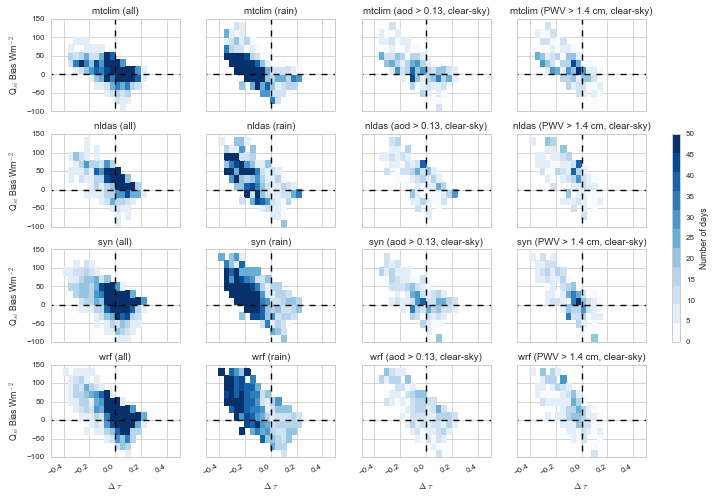

In [15]:
# ----------------------------------------------------------------------------------------
# Density Plot
# Anomaly vs bias (all)
# ----------------------------------------------------------------------------------------

# Set up details
groups_for_plot = ['south cv']
f = plt.figure(figsize=(10,8))
gs = matplotlib.gridspec.GridSpec(4,5,width_ratios=np.append(np.ones(4)*16,np.array(1.)))
cmin = 0
cmax = 50
ncol = 11
dcol = (cmax-cmin)/(ncol-1)
cmap = kgraph.cmap_discretize(cm.Blues,ncol)

anom_day_SCV = anom_day.loc[{'Grouping': 'south cv'}]
grobs_diff_SCV = grobs_diff.loc[{'Grouping': 'south cv'}]

## All
for m,pr in enumerate(pr_names):
    ax = plt.subplot(gs[m,0])
    for n,gr in enumerate(groups_for_plot):
        # axis lines
        ax.plot(np.array((-1,1)),np.array((0,0)),'k--')
        ax.plot(np.array((0,0)),np.array((-1000,1000)),'k--')
        
        X = anom_day_SCV.anom_mean.values.flatten()[np.nonzero(~np.isnan(anom_day_SCV.anom_mean.values.flatten()) &\
                                                               ~np.isnan(grobs_diff_SCV[pr].values.flatten()))]
        Y = grobs_diff_SCV[pr].values.flatten()[np.nonzero(~np.isnan(anom_day_SCV.anom_mean.values.flatten()) &\
                                                           ~np.isnan(grobs_diff_SCV[pr].values.flatten()))]
        Hall, xedges, yedges = np.histogram2d(X,Y,bins=(np.arange(-.6,.6,.04),np.arange(-200,200,20)))
        Hall = np.ma.masked_array(Hall, Hall < 5)
        X, Y = np.meshgrid(xedges, yedges)
        im = ax.pcolormesh(X.T, Y.T, Hall, cmap=cmap, vmin=cmin, vmax=cmax)
    ## Formatting
    ax.set_ylabel('Q$_{si}$ Bias Wm$^{-2}$')
    if m == len(pr_names)-1:
        ax.set_xlabel('$\Delta$ $\\tau$')
    else:
        ax.set_xticklabels([])
    ax.set_title(pr+' (all)')
    ax.set_ylim(-100,150)
    ax.set_xlim(-.5,.5)
    ax.grid()

## Rain
pthresh = 0 # Threshold between rainy and non-rainy days
grobs_diff_thresh = grobs_diff_SCV.where(grobs_diff_SCV.precip > pthresh)
anom_thresh = anom_day_SCV.where(anom_day_SCV.precip > pthresh)

for m,pr in enumerate(pr_names):
    ax = plt.subplot(gs[m,1])    
    for n,gr in enumerate(groups_for_plot):
        # axis lines
        ax.plot(np.array((-1,1)),np.array((0,0)),'k--')
        ax.plot(np.array((0,0)),np.array((-1000,1000)),'k--')
        
        X = anom_thresh.anom_mean.values.flatten()[np.nonzero(~np.isnan(anom_thresh.anom_mean.values.flatten()) &\
                                                              ~np.isnan(grobs_diff_thresh[pr].values.flatten()))]
        Y = grobs_diff_thresh[pr].values.flatten()[np.nonzero(~np.isnan(anom_thresh.anom_mean.values.flatten()) &\
                                                              ~np.isnan(grobs_diff_thresh[pr].values.flatten()))]
        Hrain, xedges, yedges = np.histogram2d(X,Y,bins=(np.arange(-.6,.6,.04),np.arange(-200,200,20)))
        Hrain = np.ma.masked_array(Hrain, Hrain < .02)
        X, Y = np.meshgrid(xedges, yedges)
        ax.pcolormesh(X.T, Y.T, Hrain/Hall,cmap=cmap,vmin=0,vmax=1)

    ## Formatting
    if m == len(pr_names)-1:
        ax.set_xlabel('$\Delta$ $\\tau$')
    else:
        ax.set_xticklabels([])
    ax.set_title(pr+' (rain)')
    ax.set_yticklabels([])
    ax.set_ylim(-100,150)
    ax.set_xlim(-.5,.5)
    ax.grid()

## Smoggy
aod_thresh = .13 # Threshold between smog and no smog
grobs_diff_thresh = grobs_diff_SCV.where(grobs_diff_SCV.aod >= aod_thresh)
anom_thresh = anom_day_SCV.where(anom_day_SCV.aod >= aod_thresh)

for m,pr in enumerate(pr_names):
    ax = plt.subplot(gs[m,2])    
    for n,gr in enumerate(groups_for_plot):
        # axis lines
        ax.plot(np.array((-1,1)),np.array((0,0)),'k--')
        ax.plot(np.array((0,0)),np.array((-1000,1000)),'k--')
        
        X = anom_thresh.anom_mean.values.flatten()[np.nonzero(~np.isnan(anom_thresh.anom_mean.values.flatten()) &\
                                                              ~np.isnan(grobs_diff_thresh[pr].values.flatten()))]
        Y = grobs_diff_thresh[pr].values.flatten()[np.nonzero(~np.isnan(anom_thresh.anom_mean.values.flatten()) &\
                                                              ~np.isnan(grobs_diff_thresh[pr].values.flatten()))]
        Haod, xedges, yedges = np.histogram2d(X,Y,bins=(np.arange(-.6,.6,.04),np.arange(-200,200,20)))
        Haod = np.ma.masked_array(Haod, Haod < .02)
        X, Y = np.meshgrid(xedges, yedges)
        ax.pcolormesh(X.T, Y.T, Haod/Hall,cmap=cmap,vmin=0,vmax=1)

    ## Formatting
    if m == len(pr_names)-1:
        ax.set_xlabel('$\Delta$ $\\tau$')
    else:
        ax.set_xticklabels([])
    ax.set_title(pr+' (aod > 0.13, clear-sky)')
    ax.set_yticklabels([])
    ax.set_ylim(-100,150)
    ax.set_xlim(-.5,.5)
    ax.grid()
    
## Water Vapor
wv_thresh = 1.4 # Threshold between smog and no smog
grobs_diff_thresh = grobs_diff_SCV.where(grobs_diff_SCV.wv >= wv_thresh)
anom_thresh = anom_day_SCV.where(anom_day_SCV.wv >= wv_thresh)

for m,pr in enumerate(pr_names):
    ax = plt.subplot(gs[m,3])    
    for n,gr in enumerate(groups_for_plot):
        # axis lines
        ax.plot(np.array((-1,1)),np.array((0,0)),'k--')
        ax.plot(np.array((0,0)),np.array((-1000,1000)),'k--')
        
        X = anom_thresh.anom_mean.values.flatten()[np.nonzero(~np.isnan(anom_thresh.anom_mean.values.flatten()) &\
                                                              ~np.isnan(grobs_diff_thresh[pr].values.flatten()))]
        Y = grobs_diff_thresh[pr].values.flatten()[np.nonzero(~np.isnan(anom_thresh.anom_mean.values.flatten()) &\
                                                              ~np.isnan(grobs_diff_thresh[pr].values.flatten()))]
        Hpwv, xedges, yedges = np.histogram2d(X,Y,bins=(np.arange(-.6,.6,.04),np.arange(-200,200,20)))
        Hpwv = np.ma.masked_array(Hpwv, Hpwv < .02)
        X, Y = np.meshgrid(xedges, yedges)
        ax.pcolormesh(X.T, Y.T, Hpwv/Hall, cmap=cmap, vmin=0, vmax=1)

    ## Formatting
    if m == len(pr_names)-1:
        ax.set_xlabel('$\Delta$ $\\tau$')
    else:
        ax.set_xticklabels([])
    ax.set_title(pr+' (PWV > 1.4 cm, clear-sky)')
    ax.set_yticklabels([])
    ax.set_ylim(-100,150)
    ax.set_xlim(-.5,.5)
    ax.grid()
    
# Colorbar
caxi = plt.subplot(gs[1:3,-1])
cbar=plt.colorbar(im, cax=caxi, orientation = "vertical",spacing='proportional')
cbar.ax.set_ylabel('Number of days')
plt.tight_layout()
f.autofmt_xdate()

In [34]:
# ----------------------------------------------------------------------------------------
# Density Plot
# Anomaly vs bias (all)
# ----------------------------------------------------------------------------------------

# Set up details
groups_for_plot = ['south cv']
anom_day_SCV = anom_day.loc[{'Grouping': 'south cv'}]
grobs_diff_SCV = grobs_diff.loc[{'Grouping': 'south cv'}]

## All
for m,pr in enumerate(pr_names):
    for n,gr in enumerate(groups_for_plot):
        X = anom_day_SCV.anom_mean.values.flatten()[np.nonzero(~np.isnan(anom_day_SCV.anom_mean.values.flatten()) &\
                                                               ~np.isnan(grobs_diff_SCV[pr].values.flatten()))]
        Y = grobs_diff_SCV[pr].values.flatten()[np.nonzero(~np.isnan(anom_day_SCV.anom_mean.values.flatten()) &\
                                                           ~np.isnan(grobs_diff_SCV[pr].values.flatten()))]
        [s, b, r, p, err] = stats.linregress(X, Y)
        print('All ' + pr + ' r: ' + str(r))
        print('All ' + pr + ' slope: ' + str(s))
## Rain
pthresh = 0 # Threshold between rainy and non-rainy days
grobs_diff_thresh = grobs_diff_SCV.where(grobs_diff_SCV.precip > pthresh)
anom_thresh = anom_day_SCV.where(anom_day_SCV.precip > pthresh)

for m,pr in enumerate(pr_names):
    for n,gr in enumerate(groups_for_plot):
        X = anom_thresh.anom_mean.values.flatten()[np.nonzero(~np.isnan(anom_thresh.anom_mean.values.flatten()) &\
                                                              ~np.isnan(grobs_diff_thresh[pr].values.flatten()))]
        Y = grobs_diff_thresh[pr].values.flatten()[np.nonzero(~np.isnan(anom_thresh.anom_mean.values.flatten()) &\
                                                              ~np.isnan(grobs_diff_thresh[pr].values.flatten()))]
        [s, b, r, p, err] = stats.linregress(X, Y)
        print('Rain ' + pr + ' r: ' + str(r))
        print('Rain ' + pr + ' slope: ' + str(s))
## Smoggy
aod_thresh = .13 # Threshold between smog and no smog
grobs_diff_thresh = grobs_diff_SCV.where(grobs_diff_SCV.aod >= aod_thresh)
anom_thresh = anom_day_SCV.where(anom_day_SCV.aod >= aod_thresh)

for m,pr in enumerate(pr_names):
    for n,gr in enumerate(groups_for_plot):
        X = anom_thresh.anom_mean.values.flatten()[np.nonzero(~np.isnan(anom_thresh.anom_mean.values.flatten()) &\
                                                              ~np.isnan(grobs_diff_thresh[pr].values.flatten()))]
        Y = grobs_diff_thresh[pr].values.flatten()[np.nonzero(~np.isnan(anom_thresh.anom_mean.values.flatten()) &\
                                                              ~np.isnan(grobs_diff_thresh[pr].values.flatten()))]
        [s, b, r, p, err] = stats.linregress(X, Y)
        print('aod ' + pr + ' r: ' + str(r))
        print('aod ' + pr + ' slope: ' + str(s))

## Water Vapor
wv_thresh = 1.4 # Threshold between smog and no smog
grobs_diff_thresh = grobs_diff_SCV.where(grobs_diff_SCV.wv >= wv_thresh)
anom_thresh = anom_day_SCV.where(anom_day_SCV.wv >= wv_thresh)

for m,pr in enumerate(pr_names):
    for n,gr in enumerate(groups_for_plot):
        X = anom_thresh.anom_mean.values.flatten()[np.nonzero(~np.isnan(anom_thresh.anom_mean.values.flatten()) &\
                                                              ~np.isnan(grobs_diff_thresh[pr].values.flatten()))]
        Y = grobs_diff_thresh[pr].values.flatten()[np.nonzero(~np.isnan(anom_thresh.anom_mean.values.flatten()) &\
                                                              ~np.isnan(grobs_diff_thresh[pr].values.flatten()))]
        [s, b, r, p, err] = stats.linregress(X, Y)
        print('pwv ' + pr + ' r: ' + str(r))
        print('pwv ' + pr + ' slope: ' + str(s))


All mtclim r: -0.561243391579
All mtclim slope: -124.364937023
All nldas r: -0.546197829509
All nldas slope: -171.370262102
All syn r: -0.492759115656
All syn slope: -143.292234897
All wrf r: -0.58369866487
All wrf slope: -188.4229835
Rain mtclim r: -0.616012500858
Rain mtclim slope: -125.492158165
Rain nldas r: -0.598514522523
Rain nldas slope: -171.376214534
Rain syn r: -0.562271951092
Rain syn slope: -154.004122773
Rain wrf r: -0.617028677481
Rain wrf slope: -191.170063609
aod mtclim r: -0.640974934858
aod mtclim slope: -163.013906571
aod nldas r: -0.645392206108
aod nldas slope: -217.741464086
aod syn r: -0.574016868188
aod syn slope: -169.188358916
aod wrf r: -0.663766375197
aod wrf slope: -225.986586892
pwv mtclim r: -0.672367511173
pwv mtclim slope: -193.597640751
pwv nldas r: -0.638265701085
pwv nldas slope: -244.13721116
pwv syn r: -0.669796176231
pwv syn slope: -235.889937826
pwv wrf r: -0.71769425143
pwv wrf slope: -279.584840364


All mtclim r: -0.561243391579
All mtclim slope: -124.364937023
All nldas r: -0.546197829509
All nldas slope: -171.370262102
All syn r: -0.492759115656
All syn slope: -143.292234897
All wrf r: -0.58369866487
All wrf slope: -188.4229835


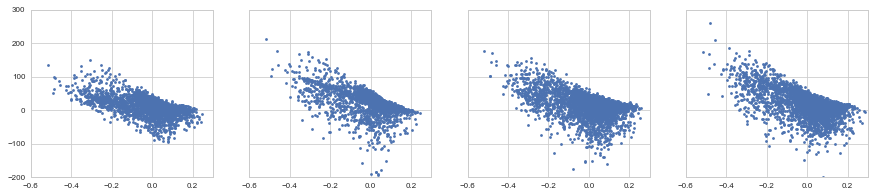

In [38]:
fig, axes = plt.subplots(1, 4, sharey=True, figsize=(15,3))
for m,pr in enumerate(pr_names):
    for n,gr in enumerate(groups_for_plot):
        X = anom_day_SCV.anom_mean.values.flatten()[np.nonzero(~np.isnan(anom_day_SCV.anom_mean.values.flatten()) &\
                                                               ~np.isnan(grobs_diff_SCV[pr].values.flatten()))]
        Y = grobs_diff_SCV[pr].values.flatten()[np.nonzero(~np.isnan(anom_day_SCV.anom_mean.values.flatten()) &\
                                                           ~np.isnan(grobs_diff_SCV[pr].values.flatten()))]
        [s, b, r, p, err] = stats.linregress(X, Y)
        print('All ' + pr + ' r: ' + str(r))
        print('All ' + pr + ' slope: ' + str(s))
        axes[m].plot(X, Y, '.')